In [1]:
import fitz  # PyMuPDF
import pdfplumber
import pandas as pd
import os
from collections import Counter

# File path
pdf_path = "Phable CAM Final.pdf"

# Extract text using PyMuPDF
doc = fitz.open(pdf_path)
text_content = ""
metadata = doc.metadata
image_count = 0

# Extract images
image_dir = "extracted_images"
os.makedirs(image_dir, exist_ok=True)

for i, page in enumerate(doc):
    text_content += page.get_text("text") + "\n\n"
    
    # Extract images
    for img_index, img in enumerate(page.get_images(full=True)):
        xref = img[0]
        base_image = doc.extract_image(xref)
        image_data = base_image["image"]
        image_ext = base_image["ext"]
        img_filename = f"{image_dir}/image_{i+1}_{img_index+1}.{image_ext}"
        with open(img_filename, "wb") as img_file:
            img_file.write(image_data)
        image_count += 1

# Extract tables using pdfplumber
table_count = 0
tables = []

with pdfplumber.open(pdf_path) as pdf:
    for page in pdf.pages:
        extracted_tables = page.extract_tables()
        for table in extracted_tables:
            df = pd.DataFrame(table).replace("", None)  # Convert empty strings to None
            
            # Heuristic filters to discard false tables
            if df.isnull().sum().sum() > 0.8 * df.size:  # Too many empty cells
                continue
            if df.shape[1] == 1 or df.shape[0] < 2:  # Single-column/row noise
                continue
            if df.applymap(lambda x: isinstance(x, str) and len(x.strip()) > 50).sum().sum() > 0.9 * df.size:
                continue  # Rejects text blocks misclassified as tables
            
            tables.append(df.values.tolist())
            table_count += len(extracted_tables)

# Count extracted elements
data_summary = Counter({"text_pages": len(doc), "tables": table_count, "images": image_count})

# Save extracted text
text_output_path = "extracted_text.txt"
with open(text_output_path, "w", encoding="utf-8") as text_file:
    text_file.write(text_content)

# Save extracted tables as JSON
import json
table_output_path = "extracted_tables.json"
with open(table_output_path, "w", encoding="utf-8") as json_file:
    json.dump(tables, json_file, indent=4)

# Output results
metadata, data_summary, text_output_path, table_output_path, image_dir


C:\Users\chira\AppData\Local\Temp\ipykernel_21852\2615977509.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if df.applymap(lambda x: isinstance(x, str) and len(x.strip()) > 50).sum().sum() > 0.9 * df.size:


({'format': 'PDF 1.4',
  'title': '',
  'author': '',
  'subject': '',
  'keywords': '',
  'creator': '',
  'producer': 'iOS Version 15.1 (Build 19B74) Quartz PDFContext',
  'creationDate': "D:20211206105506Z00'00'",
  'modDate': "D:20211206105506Z00'00'",
  'trapped': '',
  'encryption': None},
 Counter({'tables': 106, 'images': 97, 'text_pages': 35}),
 'extracted_text.txt',
 'extracted_tables.json',
 'extracted_images')

In [3]:
import json

# Save extracted tables in JSON format
tables_json_path = "extracted_tables.json"

with open(tables_json_path, "w", encoding="utf-8") as json_file:
    json.dump(tables, json_file, indent=4)

# Output table extraction result
tables_json_path


'extracted_tables.json'

In [4]:
# Read and display extracted text
text_file = "extracted_text.txt"  # Update path if needed

with open(text_file, "r", encoding="utf-8") as file:
    extracted_text = file.read()

print(extracted_text[:2000])  # Display first 2000 characters (adjust as needed)


     
                                             
 
1 
 
Proposal Summary                                                                                                                              December, 2021 
Borrower Name:  Terrals Technologies Pvt. Ltd. 
Sector: Chronic Disease Management and Healthcare Services Platform 
Proposed Amount: Up to INR 45,00,00,000  
Tranche 1: INR 10,00,00,000 
Tranche 2: Up to 15% of the equity raise (Series B) with an overall cap of INR 35Cr 
Tenor: 18 months from the date of disbursement of each tranche 
Debt XIRR: 16.56%; Warrants: 7%; XIRR with warrant upside: 31.2%  
Repayment Schedule:  
Quarterly Amortization (5 instalments); Moratorium for three months i.e., first principal instalment at the end of 6 
months. The coupons are to be serviced monthly on the last day of each month. 
Filtering Criteria: 
Criteria 
Stride Filter 
Pre-Equity 
Post-Equity* 
Equity Raised till Date 
> INR 50Cr 
INR 64Cr 
INR 192 Cr 
Debt/Equity Raised (incl. pro

Found 97 images. Displaying the first one...


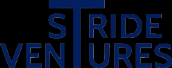

In [6]:
import os
from PIL import Image
from IPython.display import display

# Define the directory where extracted images are stored
image_dir = "extracted_images"  # Adjust path if necessary

# Check if the directory exists
if not os.path.exists(image_dir):
    print(f"Directory '{image_dir}' not found. Make sure the extraction was successful.")
else:
    # List all image files in the directory
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith((".png", ".jpg", ".jpeg"))]

    if not image_files:
        print("No images found in the directory.")
    else:
        print(f"Found {len(image_files)} images. Displaying the first one...")
        
        # Open and display the first image
        img_path = os.path.join(image_dir, image_files[0])
        img = Image.open(img_path)
        display(img)


In [8]:
import json
import pandas as pd
import os

# Load the extracted tables from the JSON file
json_path = "extracted_tables.json"  # Adjust path if necessary
with open(json_path, "r", encoding="utf-8") as f:
    tables = json.load(f)


#  Save all tables into a single Excel workbook with multiple sheets
excel_path = "readable_tables.xlsx"
with pd.ExcelWriter(excel_path) as writer:
    for i, table in enumerate(tables):
        df = pd.DataFrame(table)
        sheet_name = f"Table_{i+1}"
        df.to_excel(writer, sheet_name=sheet_name, index=False, header=False)
print(f"All tables have been saved in the Excel file: {excel_path}")


All tables have been saved in the Excel file: readable_tables.xlsx


In [11]:
import pandas as pd

# Path to the Excel file
file_path = "readable_tables.xlsx"

# Load the workbook and get sheet names
xls = pd.ExcelFile(file_path)
print("Available Sheets:", xls.sheet_names)

# Read all sheets into a dictionary of DataFrames
dfs = pd.read_excel(file_path, sheet_name=None)

# Display first few rows from each sheet
for sheet, df in dfs.items():
    print(f"\nSheet Name: {sheet}")
    print(df.head())  # Display first 5 rows


Available Sheets: ['Table_1', 'Table_2', 'Table_3', 'Table_4', 'Table_5', 'Table_6', 'Table_7', 'Table_8', 'Table_9', 'Table_10', 'Table_11', 'Table_12', 'Table_13', 'Table_14', 'Table_15', 'Table_16', 'Table_17', 'Table_18', 'Table_19', 'Table_20', 'Table_21', 'Table_22', 'Table_23', 'Table_24', 'Table_25', 'Table_26', 'Table_27', 'Table_28', 'Table_29', 'Table_30', 'Table_31', 'Table_32', 'Table_33']

Sheet Name: Table_1
                                          Unnamed: 0  \
0  Borrower Name: Terrals Technologies Pvt. Ltd.\...   

   Proposal Summary December, 2021  
0                              NaN  

Sheet Name: Table_2
                                  Unnamed: 0  Criteria  Unnamed: 2  \
0                    Equity Raised till Date       NaN         NaN   
1  Debt/Equity Raised (incl. proposed\ndebt)       NaN         NaN   
2       Debt/Valuation (incl. proposed debt)       NaN         NaN   
3     Months of Runway (excl. proposed debt)       NaN         NaN   
4              